In [4]:
import itertools
import pandas as pd
import utils
from collections import defaultdict, OrderedDict
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from scipy.sparse import hstack, vstack
import tensorflow as tf
from cnn_model import TextCNN
import data_helpers
import os
import time
import datetime
import pickle

In [5]:
ORDERED_NAMES = [u'study',
                 u'history',
                 u'comparison',
                 u'technique',
                 u'findings',
                 u'impression', 
                 u'signed by',
                 ]

--------
# Read data

In [ ]:
filename = 'Data/upto1528.xlsx'
df_raw = pd.read_excel(open(filename, 'rb'))

In [ ]:
# Data is stored in df
ps = utils.Parser()
ps.parse(df_raw)
df = ps.df
for idx, row in df['findings'].items():
    try:
        text, velos = utils.parse_findings(row)
        df.at[idx, 'findings'] = text
        for n, v in velos:
            df.at[0, n] = v
    except:
        pass
discardField = ['Report Text']
foo = [item for item in df.columns.tolist() if item not in ORDERED_NAMES + discardField]
foo.sort()
CORE_COL = ORDERED_NAMES + foo
df = df[CORE_COL]
df = pd.concat([df_raw[['Past', 'Present', 'Left', 'Right', 'Count']], df[CORE_COL]], axis=1)
# turn null to []
df = utils.null2empty(df, ['history', 'impression', 'comparison'])
print(df.shape)

In [ ]:
FIELDS = [
    'history', 
    'findings', 
    'comparison', 
    'impression'
]
df = df[['Past', 'Present'] + FIELDS]
df_processed = utils.Dataframe_Proc.strs2str(df, FIELDS)

In [ ]:
df_processed.columns

In [ ]:
# Save
pickle.dump(df_processed, open('Data/DataFrame_processed.p', 'wb'))

In [6]:
# Load
df_processed = pickle.load(open('Data/DataFrame_processed.p', 'rb'))

---
# Data Prep

In [7]:
# To predict PAST
TO_PREDICT = 'Past'
FIELDS = [
#     'history', 
    'findings', 
#     'comparison', 
    'impression'
]
df_filtered = df_processed[~df_processed[TO_PREDICT].isnull() & df_processed[TO_PREDICT] != 0].sample(frac=1, random_state=1)
df_filtered = df_filtered[[TO_PREDICT] + FIELDS]

df_train = df_filtered.iloc[:1220]
y_train = np.array(df_train[TO_PREDICT].astype(int))

df_test = df_filtered.iloc[1220:]
y_test = np.array(df_test[TO_PREDICT].astype(int))

print(df_train.shape)
print(df_test.shape)

(1220, 3)
(307, 3)


---
# Tranditional ML

### TFIDF features

In [ ]:
ngram, min_count = 5, 5

obj = utils.Df2TFIDF()
obj.fit(df_train, ngram=ngram, min_count=min_count)
output_train = obj.transform(df_train)
output_test = obj.transform(df_test)
# concatenate sparse matrices of all fields
x_train = hstack([foo['bow_tfidf'] for foo in output_train.values()])
x_test = hstack([foo['bow_tfidf'] for foo in output_test.values()])

print(x_train.shape)
print(x_test.shape)

### Run classifier

In [ ]:
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
# svm
clf = LinearSVC(C=1, loss='squared_hinge')
#clf = SVC()
#clf = LogisticRegression(C=3)

clf.fit(x_train, y_train)
coef = clf.coef_.squeeze()

In [ ]:
y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)
results = pd.concat([utils.my_classification_report(y_train, y_train_pred),
                     utils.my_classification_report(y_test, y_test_pred),
                     ], axis=1).transpose()
results.index = ['training', 'testing']
display(results)

In [ ]:
# features with the big weights
idx = np.absolute(coef).argsort()[::-1]
plt.plot(coef[idx])
plt.show()
idx2word_agg = pd.Series(obj.idx2word_concat)
display(idx2word_agg[idx[:20]])

In [ ]:
# output failed cases.
pd.set_option('display.max_colwidth', -1)
false_positive = (y_test_pred - y_test) > 0
display(df_test.loc[false_positive,:].applymap(utils.list2str))

---
---
# Neural Nets

### CNN (Field Unaware)

**Data Prep**

In [17]:
df_train.columns

Index(['Past', 'findings', 'impression'], dtype='object')

In [13]:
x_train_text = utils.Dataframe_Proc.df2text(df_train, df_train.columns[1:])
word2idx, idx2word = utils.Text_Proc.ngram_vocab_processor(x_train_text, ngram=1, min_count=2)
x_train = np.array(utils.Text_Proc.encode_texts(x_train_text, word2idx, maxlen=200))

y_train = df_train[TO_PREDICT].values[:, None]
y_train = np.concatenate([(y_train + 1) / 2, (1 - y_train) / 2], axis=1).astype(np.int)

x_dev_text = utils.Dataframe_Proc.df2text(df_test, df_test.columns[1:])
x_dev = np.array(utils.Text_Proc.encode_texts(x_dev_text, word2idx, maxlen=x_train.shape[1]))

y_dev = df_test[TO_PREDICT].values[:, None]
y_dev = np.concatenate([(y_dev + 1) / 2, (1 - y_dev) / 2], axis=1).astype(np.int)

**Run CNN**

In [14]:
# Model Hyperparameters
tf.flags.DEFINE_integer("embedding_dim", 128, "Dimensionality of character embedding (default: 128)")
tf.flags.DEFINE_string("filter_sizes", "3,4,5", "Comma-separated filter sizes (default: '3,4,5')")
tf.flags.DEFINE_integer("num_filters", 128, "Number of filters per filter size (default: 128)")
tf.flags.DEFINE_float("dropout_keep_prob", 0.5, "Dropout keep probability (default: 0.5)")
tf.flags.DEFINE_float("l2_reg_lambda", 0.0, "L2 regularization lambda (default: 0.0)")

# Training parameters
tf.flags.DEFINE_integer("batch_size", 64, "Batch Size (default: 64)")
tf.flags.DEFINE_integer("num_epochs", 200, "Number of training epochs (default: 200)")
tf.flags.DEFINE_integer("evaluate_every", 100, "Evaluate model on dev set after this many steps (default: 100)")
tf.flags.DEFINE_integer("checkpoint_every", 100, "Save model after this many steps (default: 100)")
tf.flags.DEFINE_integer("num_checkpoints", 5, "Number of checkpoints to store (default: 5)")
# Misc Parameters
tf.flags.DEFINE_boolean("allow_soft_placement", True, "Allow device soft device placement")
tf.flags.DEFINE_boolean("log_device_placement", False, "Log placement of ops on devices")

FLAGS = tf.flags.FLAGS
FLAGS._parse_flags()

['-f',
 '/run/user/1000/jupyter/kernel-986cdb23-ed26-442e-a33c-a0de17a5c689.json']

In [15]:
with tf.Graph().as_default():
    session_conf = tf.ConfigProto(
      allow_soft_placement=FLAGS.allow_soft_placement,
      log_device_placement=FLAGS.log_device_placement)
    sess = tf.Session(config=session_conf)
    with sess.as_default():
        cnn = TextCNN(
            sequence_length=x_train.shape[1],
            num_classes=y_train.shape[1],
            vocab_size=len(word2idx),
            embedding_size=FLAGS.embedding_dim,
            filter_sizes=list(map(int, FLAGS.filter_sizes.split(","))),
            num_filters=FLAGS.num_filters,
            l2_reg_lambda=FLAGS.l2_reg_lambda)

        # Define Training procedure
        global_step = tf.Variable(0, name="global_step", trainable=False)
        optimizer = tf.train.AdamOptimizer(1e-3)
        grads_and_vars = optimizer.compute_gradients(cnn.loss)
        train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

        # Keep track of gradient values and sparsity (optional)
        grad_summaries = []
        for g, v in grads_and_vars:
            if g is not None:
                grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name), g)
                sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
                grad_summaries.append(grad_hist_summary)
                grad_summaries.append(sparsity_summary)
        grad_summaries_merged = tf.summary.merge(grad_summaries)

        # Output directory for models and summaries
        timestamp = str(int(time.time()))
        out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp))
        print("Writing to {}\n".format(out_dir))

        # Summaries for loss and accuracy
        loss_summary = tf.summary.scalar("loss", cnn.loss)
        acc_summary = tf.summary.scalar("accuracy", cnn.accuracy)

        # Train Summaries
        train_summary_op = tf.summary.merge([loss_summary, acc_summary, grad_summaries_merged])
        train_summary_dir = os.path.join(out_dir, "summaries", "train")
        train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

        # Dev summaries
        dev_summary_op = tf.summary.merge([loss_summary, acc_summary])
        dev_summary_dir = os.path.join(out_dir, "summaries", "dev")
        dev_summary_writer = tf.summary.FileWriter(dev_summary_dir, sess.graph)

        # Checkpoint directory. Tensorflow assumes this directory already exists so we need to create it
        checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
        checkpoint_prefix = os.path.join(checkpoint_dir, "model")
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
        saver = tf.train.Saver(tf.global_variables(), max_to_keep=FLAGS.num_checkpoints)

        # Write vocabulary
        # vocab_processor.save(os.path.join(out_dir, "vocab"))

        # Initialize all variables
        sess.run(tf.global_variables_initializer())

        def train_step(x_batch, y_batch):
            """
            A single training step
            """
            feed_dict = {
              cnn.input_x: x_batch,
              cnn.input_y: y_batch,
              cnn.dropout_keep_prob: FLAGS.dropout_keep_prob
            }
            _, step, summaries, loss, accuracy = sess.run(
                [train_op, global_step, train_summary_op, cnn.loss, cnn.accuracy],
                feed_dict)
            time_str = datetime.datetime.now().isoformat()
            print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
            train_summary_writer.add_summary(summaries, step)

        def dev_step(x_batch, y_batch, writer=None):
            """
            Evaluates model on a dev set
            """
            feed_dict = {
              cnn.input_x: x_batch,
              cnn.input_y: y_batch,
              cnn.dropout_keep_prob: 1.0
            }
            step, summaries, loss, accuracy = sess.run(
                [global_step, dev_summary_op, cnn.loss, cnn.accuracy],
                feed_dict)
            time_str = datetime.datetime.now().isoformat()
            print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
            if writer:
                writer.add_summary(summaries, step)

        # Generate batches
        batches = data_helpers.batch_iter(
            list(zip(x_train, y_train)), FLAGS.batch_size, FLAGS.num_epochs)
        # Training loop. For each batch...
        for batch in batches:
            x_batch, y_batch = zip(*batch)
            train_step(x_batch, y_batch)
            current_step = tf.train.global_step(sess, global_step)
            if current_step % FLAGS.evaluate_every == 0:
                print("\nEvaluation:")
                dev_step(x_dev, y_dev, writer=dev_summary_writer)
                print("")
            if current_step % FLAGS.checkpoint_every == 0:
                path = saver.save(sess, checkpoint_prefix, global_step=current_step)
                print("Saved model checkpoint to {}\n".format(path))

INFO:tensorflow:Summary name embedding/W:0/grad/hist is illegal; using embedding/W_0/grad/hist instead.
INFO:tensorflow:Summary name embedding/W:0/grad/sparsity is illegal; using embedding/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/W:0/grad/hist is illegal; using conv-maxpool-3/W_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/W:0/grad/sparsity is illegal; using conv-maxpool-3/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/hist is illegal; using conv-maxpool-3/b_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/sparsity is illegal; using conv-maxpool-3/b_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-4/W:0/grad/hist is illegal; using conv-maxpool-4/W_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-4/W:0/grad/sparsity is illegal; using conv-maxpool-4/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-4/b:0/grad/hist is illegal; using 

2018-05-20T13:38:45.795993: step 98, loss 0.866225, acc 0.75
2018-05-20T13:38:45.817625: step 99, loss 0.981052, acc 0.8125
2018-05-20T13:38:45.827112: step 100, loss 0.103515, acc 1

Evaluation:
2018-05-20T13:38:45.912865: step 100, loss 0.64213, acc 0.833876

Saved model checkpoint to /home/vzhao/Documents/Projects/Med-NLP/runs/1526837922/checkpoints/model-100

2018-05-20T13:38:45.982762: step 101, loss 0.772413, acc 0.84375
2018-05-20T13:38:46.008467: step 102, loss 0.728305, acc 0.796875
2018-05-20T13:38:46.031661: step 103, loss 0.689109, acc 0.8125
2018-05-20T13:38:46.058143: step 104, loss 0.432108, acc 0.890625
2018-05-20T13:38:46.080646: step 105, loss 1.00702, acc 0.828125
2018-05-20T13:38:46.105314: step 106, loss 0.60391, acc 0.84375
2018-05-20T13:38:46.129302: step 107, loss 0.392366, acc 0.90625
2018-05-20T13:38:46.152377: step 108, loss 1.32125, acc 0.734375
2018-05-20T13:38:46.173676: step 109, loss 0.694048, acc 0.796875
2018-05-20T13:38:46.197771: step 110, loss 0.505

2018-05-20T13:38:49.033672: step 227, loss 0.639032, acc 0.84375
2018-05-20T13:38:49.056047: step 228, loss 0.546733, acc 0.890625
2018-05-20T13:38:49.079459: step 229, loss 0.548093, acc 0.796875
2018-05-20T13:38:49.103311: step 230, loss 0.558311, acc 0.8125
2018-05-20T13:38:49.129266: step 231, loss 0.679905, acc 0.859375
2018-05-20T13:38:49.151422: step 232, loss 0.295488, acc 0.90625
2018-05-20T13:38:49.171617: step 233, loss 0.342649, acc 0.890625
2018-05-20T13:38:49.196143: step 234, loss 0.781281, acc 0.765625
2018-05-20T13:38:49.221580: step 235, loss 0.488281, acc 0.859375
2018-05-20T13:38:49.246889: step 236, loss 0.119573, acc 0.9375
2018-05-20T13:38:49.270841: step 237, loss 0.536214, acc 0.84375
2018-05-20T13:38:49.294453: step 238, loss 0.62225, acc 0.875
2018-05-20T13:38:49.320637: step 239, loss 0.644496, acc 0.75
2018-05-20T13:38:49.335926: step 240, loss 0.874375, acc 0.75
2018-05-20T13:38:49.361146: step 241, loss 0.523548, acc 0.859375
2018-05-20T13:38:49.386428: s

2018-05-20T13:38:52.245986: step 357, loss 0.191424, acc 0.953125
2018-05-20T13:38:52.270880: step 358, loss 0.267132, acc 0.921875
2018-05-20T13:38:52.296318: step 359, loss 0.570024, acc 0.84375
2018-05-20T13:38:52.306964: step 360, loss 0.00284589, acc 1
2018-05-20T13:38:52.330240: step 361, loss 0.308743, acc 0.890625
2018-05-20T13:38:52.352593: step 362, loss 0.165173, acc 0.9375
2018-05-20T13:38:52.375276: step 363, loss 0.271214, acc 0.90625
2018-05-20T13:38:52.405120: step 364, loss 0.266815, acc 0.953125
2018-05-20T13:38:52.434000: step 365, loss 0.179778, acc 0.953125
2018-05-20T13:38:52.456528: step 366, loss 0.181973, acc 0.921875
2018-05-20T13:38:52.479537: step 367, loss 0.187319, acc 0.9375
2018-05-20T13:38:52.502733: step 368, loss 0.165762, acc 0.953125
2018-05-20T13:38:52.527864: step 369, loss 0.330572, acc 0.875
2018-05-20T13:38:52.553323: step 370, loss 0.312123, acc 0.921875
2018-05-20T13:38:52.580606: step 371, loss 0.465285, acc 0.90625
2018-05-20T13:38:52.60399

2018-05-20T13:38:55.451795: step 486, loss 0.186543, acc 0.90625
2018-05-20T13:38:55.472576: step 487, loss 0.0938406, acc 0.9375
2018-05-20T13:38:55.495174: step 488, loss 0.101669, acc 0.96875
2018-05-20T13:38:55.518991: step 489, loss 0.34874, acc 0.890625
2018-05-20T13:38:55.544646: step 490, loss 0.320311, acc 0.90625
2018-05-20T13:38:55.571283: step 491, loss 0.220573, acc 0.921875
2018-05-20T13:38:55.596703: step 492, loss 0.273564, acc 0.9375
2018-05-20T13:38:55.622100: step 493, loss 0.117206, acc 0.953125
2018-05-20T13:38:55.646099: step 494, loss 0.369288, acc 0.9375
2018-05-20T13:38:55.671271: step 495, loss 0.199266, acc 0.9375
2018-05-20T13:38:55.695087: step 496, loss 0.229102, acc 0.921875
2018-05-20T13:38:55.721477: step 497, loss 0.367328, acc 0.9375
2018-05-20T13:38:55.746037: step 498, loss 0.147962, acc 0.921875
2018-05-20T13:38:55.771795: step 499, loss 0.248138, acc 0.921875
2018-05-20T13:38:55.781280: step 500, loss 0.0429408, acc 1

Evaluation:
2018-05-20T13:38

2018-05-20T13:38:58.521896: step 609, loss 0.31269, acc 0.9375
2018-05-20T13:38:58.547501: step 610, loss 0.231532, acc 0.9375
2018-05-20T13:38:58.579243: step 611, loss 0.178167, acc 0.921875
2018-05-20T13:38:58.602497: step 612, loss 0.177514, acc 0.953125
2018-05-20T13:38:58.625787: step 613, loss 0.0455368, acc 0.984375
2018-05-20T13:38:58.649029: step 614, loss 0.214816, acc 0.9375
2018-05-20T13:38:58.672898: step 615, loss 0.265392, acc 0.921875
2018-05-20T13:38:58.695930: step 616, loss 0.146663, acc 0.953125
2018-05-20T13:38:58.720084: step 617, loss 0.498865, acc 0.890625
2018-05-20T13:38:58.746240: step 618, loss 0.0745516, acc 0.953125
2018-05-20T13:38:58.770306: step 619, loss 0.421246, acc 0.90625
2018-05-20T13:38:58.780073: step 620, loss 0.00246881, acc 1
2018-05-20T13:38:58.802334: step 621, loss 0.0824775, acc 0.96875
2018-05-20T13:38:58.827700: step 622, loss 0.146874, acc 0.921875
2018-05-20T13:38:58.853861: step 623, loss 0.0848646, acc 0.96875
2018-05-20T13:38:58.8

2018-05-20T13:39:01.561573: step 733, loss 0.106159, acc 0.9375
2018-05-20T13:39:01.589731: step 734, loss 0.108429, acc 0.984375
2018-05-20T13:39:01.610594: step 735, loss 0.13541, acc 0.96875
2018-05-20T13:39:01.631638: step 736, loss 0.0739166, acc 0.984375
2018-05-20T13:39:01.655262: step 737, loss 0.122287, acc 0.953125
2018-05-20T13:39:01.679267: step 738, loss 0.16294, acc 0.953125
2018-05-20T13:39:01.703598: step 739, loss 0.206677, acc 0.9375
2018-05-20T13:39:01.713951: step 740, loss 0.0948451, acc 1
2018-05-20T13:39:01.736477: step 741, loss 0.0653905, acc 0.96875
2018-05-20T13:39:01.760169: step 742, loss 0.165489, acc 0.921875
2018-05-20T13:39:01.782776: step 743, loss 0.260561, acc 0.890625
2018-05-20T13:39:01.805142: step 744, loss 0.143999, acc 0.9375
2018-05-20T13:39:01.827261: step 745, loss 0.0792169, acc 0.96875
2018-05-20T13:39:01.851858: step 746, loss 0.0531077, acc 0.984375
2018-05-20T13:39:01.876447: step 747, loss 0.178774, acc 0.921875
2018-05-20T13:39:01.900

2018-05-20T13:39:04.589302: step 859, loss 0.135683, acc 0.9375
2018-05-20T13:39:04.600097: step 860, loss 0.0563256, acc 1
2018-05-20T13:39:04.621245: step 861, loss 0.06749, acc 0.96875
2018-05-20T13:39:04.645613: step 862, loss 0.0975871, acc 0.953125
2018-05-20T13:39:04.669120: step 863, loss 0.0356894, acc 0.984375
2018-05-20T13:39:04.693737: step 864, loss 0.0766492, acc 0.984375
2018-05-20T13:39:04.719283: step 865, loss 0.148791, acc 0.96875
2018-05-20T13:39:04.743897: step 866, loss 0.0701542, acc 0.984375
2018-05-20T13:39:04.768149: step 867, loss 0.312126, acc 0.921875
2018-05-20T13:39:04.791956: step 868, loss 0.171441, acc 0.921875
2018-05-20T13:39:04.814671: step 869, loss 0.0874598, acc 0.96875
2018-05-20T13:39:04.838461: step 870, loss 0.0522058, acc 0.984375
2018-05-20T13:39:04.864347: step 871, loss 0.149797, acc 0.953125
2018-05-20T13:39:04.887654: step 872, loss 0.0380755, acc 1
2018-05-20T13:39:04.910551: step 873, loss 0.0724266, acc 0.96875
2018-05-20T13:39:04.93

2018-05-20T13:39:07.564226: step 983, loss 0.173221, acc 0.953125
2018-05-20T13:39:07.587347: step 984, loss 0.0209698, acc 1
2018-05-20T13:39:07.609532: step 985, loss 0.11655, acc 0.953125
2018-05-20T13:39:07.635217: step 986, loss 0.165372, acc 0.9375
2018-05-20T13:39:07.658317: step 987, loss 0.0299753, acc 0.984375
2018-05-20T13:39:07.682104: step 988, loss 0.0986961, acc 0.96875
2018-05-20T13:39:07.707182: step 989, loss 0.125668, acc 0.96875
2018-05-20T13:39:07.729815: step 990, loss 0.0380059, acc 0.984375
2018-05-20T13:39:07.759383: step 991, loss 0.122408, acc 0.9375
2018-05-20T13:39:07.784916: step 992, loss 0.139365, acc 0.9375
2018-05-20T13:39:07.808073: step 993, loss 0.0383428, acc 1
2018-05-20T13:39:07.829553: step 994, loss 0.102288, acc 0.96875
2018-05-20T13:39:07.852612: step 995, loss 0.0165869, acc 1
2018-05-20T13:39:07.874665: step 996, loss 0.0529186, acc 0.96875
2018-05-20T13:39:07.898915: step 997, loss 0.0135723, acc 1
2018-05-20T13:39:07.921110: step 998, los

2018-05-20T13:39:10.592875: step 1105, loss 0.0830651, acc 0.953125
2018-05-20T13:39:10.615692: step 1106, loss 0.0228368, acc 1
2018-05-20T13:39:10.640784: step 1107, loss 0.142977, acc 0.96875
2018-05-20T13:39:10.666371: step 1108, loss 0.0554253, acc 0.984375
2018-05-20T13:39:10.692083: step 1109, loss 0.103385, acc 0.96875
2018-05-20T13:39:10.715251: step 1110, loss 0.0512098, acc 0.984375
2018-05-20T13:39:10.740174: step 1111, loss 0.116176, acc 0.96875
2018-05-20T13:39:10.762218: step 1112, loss 0.0455909, acc 0.984375
2018-05-20T13:39:10.787131: step 1113, loss 0.143167, acc 0.953125
2018-05-20T13:39:10.811720: step 1114, loss 0.0444442, acc 0.984375
2018-05-20T13:39:10.835545: step 1115, loss 0.0369937, acc 0.984375
2018-05-20T13:39:10.859304: step 1116, loss 0.0855883, acc 0.96875
2018-05-20T13:39:10.882302: step 1117, loss 0.149908, acc 0.921875
2018-05-20T13:39:10.903958: step 1118, loss 0.120184, acc 0.984375
2018-05-20T13:39:10.924895: step 1119, loss 0.0304996, acc 0.9843

2018-05-20T13:39:13.607361: step 1231, loss 0.0194894, acc 1
2018-05-20T13:39:13.632231: step 1232, loss 0.0397702, acc 0.984375
2018-05-20T13:39:13.654734: step 1233, loss 0.087371, acc 0.96875
2018-05-20T13:39:13.678569: step 1234, loss 0.00758143, acc 1
2018-05-20T13:39:13.704334: step 1235, loss 0.0439395, acc 0.96875
2018-05-20T13:39:13.728259: step 1236, loss 0.019357, acc 1
2018-05-20T13:39:13.752308: step 1237, loss 0.0238037, acc 1
2018-05-20T13:39:13.779260: step 1238, loss 0.128422, acc 0.984375
2018-05-20T13:39:13.802547: step 1239, loss 0.30271, acc 0.90625
2018-05-20T13:39:13.814543: step 1240, loss 0.00177846, acc 1
2018-05-20T13:39:13.839512: step 1241, loss 0.0253572, acc 0.984375
2018-05-20T13:39:13.862799: step 1242, loss 0.168498, acc 0.96875
2018-05-20T13:39:13.892120: step 1243, loss 0.118755, acc 0.96875
2018-05-20T13:39:13.916620: step 1244, loss 0.102842, acc 0.96875
2018-05-20T13:39:13.943610: step 1245, loss 0.036259, acc 0.984375
2018-05-20T13:39:13.968410: 

2018-05-20T13:39:16.837036: step 1363, loss 0.0158177, acc 1
2018-05-20T13:39:16.860620: step 1364, loss 0.0163524, acc 1
2018-05-20T13:39:16.883610: step 1365, loss 0.067445, acc 0.984375
2018-05-20T13:39:16.910425: step 1366, loss 0.0588229, acc 0.96875
2018-05-20T13:39:16.935307: step 1367, loss 0.0160639, acc 1
2018-05-20T13:39:16.959488: step 1368, loss 0.00867078, acc 1
2018-05-20T13:39:16.985217: step 1369, loss 0.103129, acc 0.96875
2018-05-20T13:39:17.011326: step 1370, loss 0.0318577, acc 0.984375
2018-05-20T13:39:17.037053: step 1371, loss 0.00723433, acc 1
2018-05-20T13:39:17.061884: step 1372, loss 0.0389033, acc 0.984375
2018-05-20T13:39:17.085681: step 1373, loss 0.00800841, acc 1
2018-05-20T13:39:17.109180: step 1374, loss 0.00896788, acc 1
2018-05-20T13:39:17.135849: step 1375, loss 0.00957087, acc 1
2018-05-20T13:39:17.160260: step 1376, loss 0.0210605, acc 1
2018-05-20T13:39:17.183244: step 1377, loss 0.0385069, acc 0.984375
2018-05-20T13:39:17.205150: step 1378, los

2018-05-20T13:39:19.884719: step 1487, loss 0.00801657, acc 1
2018-05-20T13:39:19.909053: step 1488, loss 0.123935, acc 0.96875
2018-05-20T13:39:19.930249: step 1489, loss 0.0119731, acc 1
2018-05-20T13:39:19.955425: step 1490, loss 0.165719, acc 0.984375
2018-05-20T13:39:19.981795: step 1491, loss 0.0426742, acc 0.984375
2018-05-20T13:39:20.005404: step 1492, loss 0.0231496, acc 1
2018-05-20T13:39:20.029958: step 1493, loss 0.0767826, acc 0.96875
2018-05-20T13:39:20.053593: step 1494, loss 0.0269299, acc 1
2018-05-20T13:39:20.077151: step 1495, loss 0.0430486, acc 0.984375
2018-05-20T13:39:20.102999: step 1496, loss 0.132253, acc 0.921875
2018-05-20T13:39:20.124877: step 1497, loss 0.0134562, acc 1
2018-05-20T13:39:20.146935: step 1498, loss 0.0131394, acc 1
2018-05-20T13:39:20.169686: step 1499, loss 0.0813504, acc 0.984375
2018-05-20T13:39:20.181401: step 1500, loss 0.00473265, acc 1

Evaluation:
2018-05-20T13:39:20.199684: step 1500, loss 0.423297, acc 0.872964

Saved model checkpo

2018-05-20T13:39:22.865969: step 1610, loss 0.0859908, acc 0.984375
2018-05-20T13:39:22.891034: step 1611, loss 0.00809126, acc 1
2018-05-20T13:39:22.913009: step 1612, loss 0.0114023, acc 1
2018-05-20T13:39:22.937700: step 1613, loss 0.0393298, acc 0.984375
2018-05-20T13:39:22.963302: step 1614, loss 0.0760242, acc 0.96875
2018-05-20T13:39:22.986800: step 1615, loss 0.0990887, acc 0.96875
2018-05-20T13:39:23.011854: step 1616, loss 0.0593153, acc 0.96875
2018-05-20T13:39:23.036919: step 1617, loss 0.007289, acc 1
2018-05-20T13:39:23.061957: step 1618, loss 0.029483, acc 1
2018-05-20T13:39:23.086135: step 1619, loss 0.0224943, acc 0.984375
2018-05-20T13:39:23.096235: step 1620, loss 0.000592269, acc 1
2018-05-20T13:39:23.118596: step 1621, loss 0.0347418, acc 0.984375
2018-05-20T13:39:23.143227: step 1622, loss 0.00979335, acc 1
2018-05-20T13:39:23.164533: step 1623, loss 0.0380299, acc 1
2018-05-20T13:39:23.188265: step 1624, loss 0.0164134, acc 1
2018-05-20T13:39:23.210069: step 1625

2018-05-20T13:39:25.919315: step 1737, loss 0.0281264, acc 0.984375
2018-05-20T13:39:25.941172: step 1738, loss 0.0649848, acc 0.96875
2018-05-20T13:39:25.964211: step 1739, loss 0.0420645, acc 0.984375
2018-05-20T13:39:25.980000: step 1740, loss 0.00119796, acc 1
2018-05-20T13:39:26.007307: step 1741, loss 0.130975, acc 0.96875
2018-05-20T13:39:26.028922: step 1742, loss 0.0131826, acc 1
2018-05-20T13:39:26.056941: step 1743, loss 0.0151453, acc 1
2018-05-20T13:39:26.079846: step 1744, loss 0.00616176, acc 1
2018-05-20T13:39:26.105111: step 1745, loss 0.0331636, acc 0.984375
2018-05-20T13:39:26.132720: step 1746, loss 0.0906591, acc 0.984375
2018-05-20T13:39:26.156001: step 1747, loss 0.12431, acc 0.96875
2018-05-20T13:39:26.177568: step 1748, loss 0.0148478, acc 1
2018-05-20T13:39:26.200959: step 1749, loss 0.0349975, acc 0.984375
2018-05-20T13:39:26.224097: step 1750, loss 0.0207434, acc 1
2018-05-20T13:39:26.250105: step 1751, loss 0.00632308, acc 1
2018-05-20T13:39:26.271123: step

2018-05-20T13:39:28.922697: step 1863, loss 0.0254682, acc 1
2018-05-20T13:39:28.944881: step 1864, loss 0.0724959, acc 0.984375
2018-05-20T13:39:28.969251: step 1865, loss 0.0998055, acc 0.96875
2018-05-20T13:39:28.995257: step 1866, loss 0.037154, acc 0.96875
2018-05-20T13:39:29.019035: step 1867, loss 0.00721514, acc 1
2018-05-20T13:39:29.045108: step 1868, loss 0.00840268, acc 1
2018-05-20T13:39:29.069582: step 1869, loss 0.0204269, acc 1
2018-05-20T13:39:29.092622: step 1870, loss 0.132819, acc 0.9375
2018-05-20T13:39:29.117831: step 1871, loss 0.00989636, acc 1
2018-05-20T13:39:29.148340: step 1872, loss 0.132593, acc 0.96875
2018-05-20T13:39:29.172555: step 1873, loss 0.092298, acc 0.984375
2018-05-20T13:39:29.198056: step 1874, loss 0.00674791, acc 1
2018-05-20T13:39:29.221931: step 1875, loss 0.0138425, acc 1
2018-05-20T13:39:29.246993: step 1876, loss 0.0913495, acc 0.96875
2018-05-20T13:39:29.268683: step 1877, loss 0.213163, acc 0.953125
2018-05-20T13:39:29.292610: step 187

2018-05-20T13:39:31.956094: step 1989, loss 0.0455745, acc 0.984375
2018-05-20T13:39:31.982882: step 1990, loss 0.0321225, acc 0.984375
2018-05-20T13:39:32.006723: step 1991, loss 0.00318713, acc 1
2018-05-20T13:39:32.030360: step 1992, loss 0.0158471, acc 1
2018-05-20T13:39:32.056888: step 1993, loss 0.0341237, acc 0.984375
2018-05-20T13:39:32.080546: step 1994, loss 0.00373672, acc 1
2018-05-20T13:39:32.107511: step 1995, loss 0.028188, acc 0.984375
2018-05-20T13:39:32.129271: step 1996, loss 0.0137389, acc 1
2018-05-20T13:39:32.151066: step 1997, loss 0.0234815, acc 0.984375
2018-05-20T13:39:32.175780: step 1998, loss 0.120369, acc 0.984375
2018-05-20T13:39:32.197640: step 1999, loss 0.186702, acc 0.953125
2018-05-20T13:39:32.207850: step 2000, loss 0.00400311, acc 1

Evaluation:
2018-05-20T13:39:32.227275: step 2000, loss 0.471644, acc 0.879479

Saved model checkpoint to /home/vzhao/Documents/Projects/Med-NLP/runs/1526837922/checkpoints/model-2000

2018-05-20T13:39:32.288003: step 

2018-05-20T13:39:35.015250: step 2114, loss 0.0582762, acc 0.984375
2018-05-20T13:39:35.036162: step 2115, loss 0.00274104, acc 1
2018-05-20T13:39:35.059411: step 2116, loss 0.0579366, acc 0.984375
2018-05-20T13:39:35.083536: step 2117, loss 0.0362397, acc 0.96875
2018-05-20T13:39:35.108655: step 2118, loss 0.0533109, acc 0.984375
2018-05-20T13:39:35.132508: step 2119, loss 0.00944582, acc 1
2018-05-20T13:39:35.143889: step 2120, loss 0.000250338, acc 1
2018-05-20T13:39:35.165108: step 2121, loss 0.0161239, acc 1
2018-05-20T13:39:35.190648: step 2122, loss 0.00187408, acc 1
2018-05-20T13:39:35.216991: step 2123, loss 0.0621126, acc 0.984375
2018-05-20T13:39:35.241379: step 2124, loss 0.00433885, acc 1
2018-05-20T13:39:35.262631: step 2125, loss 0.154731, acc 0.96875
2018-05-20T13:39:35.284701: step 2126, loss 0.0327995, acc 1
2018-05-20T13:39:35.310404: step 2127, loss 0.0176604, acc 0.984375
2018-05-20T13:39:35.335232: step 2128, loss 0.0873513, acc 0.984375
2018-05-20T13:39:35.360078

2018-05-20T13:39:38.242462: step 2247, loss 0.00858789, acc 1
2018-05-20T13:39:38.265972: step 2248, loss 0.023925, acc 1
2018-05-20T13:39:38.289068: step 2249, loss 0.00532298, acc 1
2018-05-20T13:39:38.315260: step 2250, loss 0.00237694, acc 1
2018-05-20T13:39:38.339219: step 2251, loss 0.0463083, acc 0.984375
2018-05-20T13:39:38.361515: step 2252, loss 0.0877797, acc 0.984375
2018-05-20T13:39:38.385683: step 2253, loss 0.00225027, acc 1
2018-05-20T13:39:38.409290: step 2254, loss 0.0320104, acc 0.96875
2018-05-20T13:39:38.433299: step 2255, loss 0.0958677, acc 0.984375
2018-05-20T13:39:38.458836: step 2256, loss 0.000742303, acc 1
2018-05-20T13:39:38.485037: step 2257, loss 0.0354381, acc 0.984375
2018-05-20T13:39:38.508820: step 2258, loss 0.0139145, acc 1
2018-05-20T13:39:38.530907: step 2259, loss 0.0188299, acc 1
2018-05-20T13:39:38.543174: step 2260, loss 0.000483216, acc 1
2018-05-20T13:39:38.571170: step 2261, loss 0.00159207, acc 1
2018-05-20T13:39:38.596953: step 2262, loss

2018-05-20T13:39:41.435474: step 2379, loss 0.00920417, acc 1
2018-05-20T13:39:41.447017: step 2380, loss 0.00180503, acc 1
2018-05-20T13:39:41.471179: step 2381, loss 0.0322985, acc 0.984375
2018-05-20T13:39:41.496337: step 2382, loss 0.00572903, acc 1
2018-05-20T13:39:41.518166: step 2383, loss 0.0357354, acc 0.984375
2018-05-20T13:39:41.540986: step 2384, loss 0.077799, acc 0.984375
2018-05-20T13:39:41.567070: step 2385, loss 0.0127759, acc 1
2018-05-20T13:39:41.591488: step 2386, loss 0.00180768, acc 1
2018-05-20T13:39:41.616712: step 2387, loss 0.0156109, acc 1
2018-05-20T13:39:41.640752: step 2388, loss 0.0124906, acc 1
2018-05-20T13:39:41.663027: step 2389, loss 0.0019538, acc 1
2018-05-20T13:39:41.685038: step 2390, loss 0.0186191, acc 1
2018-05-20T13:39:41.706078: step 2391, loss 0.0904744, acc 0.984375
2018-05-20T13:39:41.729091: step 2392, loss 0.00731831, acc 1
2018-05-20T13:39:41.754937: step 2393, loss 0.0120786, acc 1
2018-05-20T13:39:41.776488: step 2394, loss 0.0041462

2018-05-20T13:39:44.456431: step 2502, loss 0.0394669, acc 0.96875
2018-05-20T13:39:44.479883: step 2503, loss 0.00734148, acc 1
2018-05-20T13:39:44.505699: step 2504, loss 0.018797, acc 1
2018-05-20T13:39:44.531507: step 2505, loss 0.00992751, acc 1
2018-05-20T13:39:44.555822: step 2506, loss 0.0229801, acc 1
2018-05-20T13:39:44.582765: step 2507, loss 0.0144665, acc 1
2018-05-20T13:39:44.606990: step 2508, loss 0.00664836, acc 1
2018-05-20T13:39:44.634830: step 2509, loss 0.0101931, acc 1
2018-05-20T13:39:44.654718: step 2510, loss 0.0273324, acc 0.984375
2018-05-20T13:39:44.685421: step 2511, loss 0.00951386, acc 1
2018-05-20T13:39:44.706704: step 2512, loss 0.0864063, acc 0.984375
2018-05-20T13:39:44.729795: step 2513, loss 0.0026449, acc 1
2018-05-20T13:39:44.753333: step 2514, loss 0.01548, acc 1
2018-05-20T13:39:44.779617: step 2515, loss 0.00971608, acc 1
2018-05-20T13:39:44.805252: step 2516, loss 0.0428428, acc 0.96875
2018-05-20T13:39:44.829113: step 2517, loss 0.00525604, a

2018-05-20T13:39:47.721418: step 2635, loss 0.00864589, acc 1
2018-05-20T13:39:47.744060: step 2636, loss 0.0108401, acc 1
2018-05-20T13:39:47.766369: step 2637, loss 0.0429577, acc 0.984375
2018-05-20T13:39:47.792114: step 2638, loss 0.0641684, acc 0.96875
2018-05-20T13:39:47.816468: step 2639, loss 0.060145, acc 0.984375
2018-05-20T13:39:47.828287: step 2640, loss 0.0194101, acc 1
2018-05-20T13:39:47.850977: step 2641, loss 0.00793185, acc 1
2018-05-20T13:39:47.876292: step 2642, loss 0.00801411, acc 1
2018-05-20T13:39:47.901489: step 2643, loss 0.00412664, acc 1
2018-05-20T13:39:47.925386: step 2644, loss 0.0200175, acc 0.984375
2018-05-20T13:39:47.948610: step 2645, loss 0.0073608, acc 1
2018-05-20T13:39:47.972656: step 2646, loss 0.0176928, acc 1
2018-05-20T13:39:47.996051: step 2647, loss 0.0155462, acc 1
2018-05-20T13:39:48.021973: step 2648, loss 0.0550831, acc 0.984375
2018-05-20T13:39:48.046818: step 2649, loss 0.00319507, acc 1
2018-05-20T13:39:48.070489: step 2650, loss 0.0

2018-05-20T13:39:50.769057: step 2762, loss 0.0251622, acc 1
2018-05-20T13:39:50.791267: step 2763, loss 0.0762393, acc 0.984375
2018-05-20T13:39:50.813303: step 2764, loss 0.0690412, acc 0.96875
2018-05-20T13:39:50.838530: step 2765, loss 0.0282736, acc 1
2018-05-20T13:39:50.865714: step 2766, loss 0.0398473, acc 0.984375
2018-05-20T13:39:50.889503: step 2767, loss 0.00764629, acc 1
2018-05-20T13:39:50.912955: step 2768, loss 0.0106992, acc 1
2018-05-20T13:39:50.937736: step 2769, loss 0.0103158, acc 1
2018-05-20T13:39:50.960733: step 2770, loss 0.00437273, acc 1
2018-05-20T13:39:50.986041: step 2771, loss 0.00119594, acc 1
2018-05-20T13:39:51.010667: step 2772, loss 0.0852338, acc 0.984375
2018-05-20T13:39:51.036474: step 2773, loss 0.00170862, acc 1
2018-05-20T13:39:51.059972: step 2774, loss 0.00413638, acc 1
2018-05-20T13:39:51.086803: step 2775, loss 0.0169269, acc 0.984375
2018-05-20T13:39:51.109260: step 2776, loss 0.00382775, acc 1
2018-05-20T13:39:51.135097: step 2777, loss 0

2018-05-20T13:39:54.043185: step 2897, loss 0.00295999, acc 1
2018-05-20T13:39:54.068961: step 2898, loss 0.0116535, acc 1
2018-05-20T13:39:54.092624: step 2899, loss 0.00331624, acc 1
2018-05-20T13:39:54.105914: step 2900, loss 0.000216993, acc 1

Evaluation:
2018-05-20T13:39:54.124376: step 2900, loss 0.523835, acc 0.879479

Saved model checkpoint to /home/vzhao/Documents/Projects/Med-NLP/runs/1526837922/checkpoints/model-2900

2018-05-20T13:39:54.190908: step 2901, loss 0.000918734, acc 1
2018-05-20T13:39:54.218522: step 2902, loss 0.00640567, acc 1
2018-05-20T13:39:54.244059: step 2903, loss 0.109884, acc 0.984375
2018-05-20T13:39:54.266695: step 2904, loss 0.00920709, acc 1
2018-05-20T13:39:54.289202: step 2905, loss 0.00335984, acc 1
2018-05-20T13:39:54.311666: step 2906, loss 0.00919761, acc 1
2018-05-20T13:39:54.333453: step 2907, loss 0.0043649, acc 1
2018-05-20T13:39:54.358820: step 2908, loss 0.00165501, acc 1
2018-05-20T13:39:54.383526: step 2909, loss 0.00454152, acc 1
201

2018-05-20T13:39:57.313487: step 3028, loss 0.00398377, acc 1
2018-05-20T13:39:57.336617: step 3029, loss 0.00637105, acc 1
2018-05-20T13:39:57.358329: step 3030, loss 0.0792109, acc 0.984375
2018-05-20T13:39:57.384186: step 3031, loss 0.000963719, acc 1
2018-05-20T13:39:57.409317: step 3032, loss 0.00474662, acc 1
2018-05-20T13:39:57.435008: step 3033, loss 0.0134985, acc 1
2018-05-20T13:39:57.467079: step 3034, loss 0.00237714, acc 1
2018-05-20T13:39:57.489974: step 3035, loss 0.00538783, acc 1
2018-05-20T13:39:57.513384: step 3036, loss 0.0116719, acc 1
2018-05-20T13:39:57.535870: step 3037, loss 0.00936008, acc 1
2018-05-20T13:39:57.558306: step 3038, loss 0.0102055, acc 1
2018-05-20T13:39:57.582123: step 3039, loss 0.0467233, acc 0.984375
2018-05-20T13:39:57.593240: step 3040, loss 0.0126796, acc 1
2018-05-20T13:39:57.616635: step 3041, loss 0.0141267, acc 1
2018-05-20T13:39:57.640448: step 3042, loss 0.0209453, acc 1
2018-05-20T13:39:57.663321: step 3043, loss 0.00951453, acc 1
2

2018-05-20T13:40:00.597090: step 3163, loss 0.00558314, acc 1
2018-05-20T13:40:00.620322: step 3164, loss 0.00246184, acc 1
2018-05-20T13:40:00.643442: step 3165, loss 0.0507021, acc 0.984375
2018-05-20T13:40:00.670227: step 3166, loss 0.0727699, acc 0.984375
2018-05-20T13:40:00.693953: step 3167, loss 0.0152595, acc 1
2018-05-20T13:40:00.717988: step 3168, loss 0.00826487, acc 1
2018-05-20T13:40:00.743050: step 3169, loss 0.00292895, acc 1
2018-05-20T13:40:00.768196: step 3170, loss 0.00334095, acc 1
2018-05-20T13:40:00.791780: step 3171, loss 0.0086687, acc 1
2018-05-20T13:40:00.815324: step 3172, loss 0.00825498, acc 1
2018-05-20T13:40:00.838646: step 3173, loss 0.00963024, acc 1
2018-05-20T13:40:00.861212: step 3174, loss 0.00289479, acc 1
2018-05-20T13:40:00.886508: step 3175, loss 0.0133613, acc 1
2018-05-20T13:40:00.911174: step 3176, loss 0.00600848, acc 1
2018-05-20T13:40:00.934925: step 3177, loss 0.00933935, acc 1
2018-05-20T13:40:00.960112: step 3178, loss 0.0017458, acc 1


2018-05-20T13:40:03.646415: step 3289, loss 0.00235057, acc 1
2018-05-20T13:40:03.669503: step 3290, loss 0.00776707, acc 1
2018-05-20T13:40:03.691804: step 3291, loss 0.00624707, acc 1
2018-05-20T13:40:03.716979: step 3292, loss 0.0310949, acc 0.96875
2018-05-20T13:40:03.747918: step 3293, loss 0.0673513, acc 0.984375
2018-05-20T13:40:03.773487: step 3294, loss 0.00207083, acc 1
2018-05-20T13:40:03.797990: step 3295, loss 0.0116697, acc 1
2018-05-20T13:40:03.825087: step 3296, loss 0.00221432, acc 1
2018-05-20T13:40:03.852003: step 3297, loss 0.00546003, acc 1
2018-05-20T13:40:03.874134: step 3298, loss 0.00503087, acc 1
2018-05-20T13:40:03.899884: step 3299, loss 0.0168507, acc 1
2018-05-20T13:40:03.910242: step 3300, loss 4.27038e-05, acc 1

Evaluation:
2018-05-20T13:40:03.928797: step 3300, loss 0.544243, acc 0.879479

Saved model checkpoint to /home/vzhao/Documents/Projects/Med-NLP/runs/1526837922/checkpoints/model-3300

2018-05-20T13:40:03.993386: step 3301, loss 0.00814457, acc 

2018-05-20T13:40:06.861539: step 3418, loss 0.00251932, acc 1
2018-05-20T13:40:06.886262: step 3419, loss 0.0443808, acc 0.984375
2018-05-20T13:40:06.896340: step 3420, loss 0.000429892, acc 1
2018-05-20T13:40:06.920296: step 3421, loss 0.00738158, acc 1
2018-05-20T13:40:06.945160: step 3422, loss 0.0340686, acc 0.984375
2018-05-20T13:40:06.969261: step 3423, loss 0.0174166, acc 1
2018-05-20T13:40:06.993680: step 3424, loss 0.00328852, acc 1
2018-05-20T13:40:07.020259: step 3425, loss 0.0873514, acc 0.984375
2018-05-20T13:40:07.046399: step 3426, loss 0.0211732, acc 0.984375
2018-05-20T13:40:07.072579: step 3427, loss 0.016298, acc 1
2018-05-20T13:40:07.097905: step 3428, loss 0.0345632, acc 0.96875
2018-05-20T13:40:07.119631: step 3429, loss 0.030129, acc 0.984375
2018-05-20T13:40:07.143470: step 3430, loss 0.00405005, acc 1
2018-05-20T13:40:07.168797: step 3431, loss 0.0139533, acc 1
2018-05-20T13:40:07.193773: step 3432, loss 0.020377, acc 0.984375
2018-05-20T13:40:07.215575: step 3

2018-05-20T13:40:10.117700: step 3552, loss 0.00407214, acc 1
2018-05-20T13:40:10.139457: step 3553, loss 0.000439498, acc 1
2018-05-20T13:40:10.163352: step 3554, loss 0.000930177, acc 1
2018-05-20T13:40:10.185544: step 3555, loss 0.00172005, acc 1
2018-05-20T13:40:10.207341: step 3556, loss 0.153111, acc 0.96875
2018-05-20T13:40:10.230486: step 3557, loss 0.00964845, acc 1
2018-05-20T13:40:10.256338: step 3558, loss 0.00401621, acc 1
2018-05-20T13:40:10.280098: step 3559, loss 0.00154452, acc 1
2018-05-20T13:40:10.291277: step 3560, loss 0.00254997, acc 1
2018-05-20T13:40:10.315907: step 3561, loss 0.00286372, acc 1
2018-05-20T13:40:10.338503: step 3562, loss 0.0742382, acc 0.984375
2018-05-20T13:40:10.359880: step 3563, loss 0.00386974, acc 1
2018-05-20T13:40:10.384332: step 3564, loss 0.0726395, acc 0.984375
2018-05-20T13:40:10.409898: step 3565, loss 0.00286266, acc 1
2018-05-20T13:40:10.433346: step 3566, loss 0.000909114, acc 1
2018-05-20T13:40:10.458219: step 3567, loss 0.01196

2018-05-20T13:40:13.341318: step 3686, loss 0.00351602, acc 1
2018-05-20T13:40:13.363329: step 3687, loss 0.00694091, acc 1
2018-05-20T13:40:13.388324: step 3688, loss 0.00623409, acc 1
2018-05-20T13:40:13.413066: step 3689, loss 0.0672456, acc 0.984375
2018-05-20T13:40:13.437060: step 3690, loss 0.00439586, acc 1
2018-05-20T13:40:13.458814: step 3691, loss 0.0613585, acc 0.984375
2018-05-20T13:40:13.484204: step 3692, loss 0.00729477, acc 1
2018-05-20T13:40:13.512101: step 3693, loss 0.0271341, acc 0.984375
2018-05-20T13:40:13.535919: step 3694, loss 0.0813794, acc 0.984375
2018-05-20T13:40:13.560086: step 3695, loss 0.00414543, acc 1
2018-05-20T13:40:13.584331: step 3696, loss 0.00180715, acc 1
2018-05-20T13:40:13.607527: step 3697, loss 0.0212784, acc 0.984375
2018-05-20T13:40:13.633965: step 3698, loss 0.00784836, acc 1
2018-05-20T13:40:13.658939: step 3699, loss 0.00122239, acc 1
2018-05-20T13:40:13.668384: step 3700, loss 2.70593e-05, acc 1

Evaluation:
2018-05-20T13:40:13.686866

2018-05-20T13:40:16.581699: step 3818, loss 0.00120754, acc 1
2018-05-20T13:40:16.603333: step 3819, loss 0.00294887, acc 1
2018-05-20T13:40:16.614124: step 3820, loss 0.00256609, acc 1
2018-05-20T13:40:16.636516: step 3821, loss 0.00417891, acc 1
2018-05-20T13:40:16.660449: step 3822, loss 0.00265826, acc 1
2018-05-20T13:40:16.686156: step 3823, loss 0.0082793, acc 1
2018-05-20T13:40:16.711860: step 3824, loss 0.00337618, acc 1
2018-05-20T13:40:16.736963: step 3825, loss 0.00612405, acc 1
2018-05-20T13:40:16.761106: step 3826, loss 0.00578978, acc 1
2018-05-20T13:40:16.787079: step 3827, loss 0.00898507, acc 1
2018-05-20T13:40:16.811691: step 3828, loss 0.00439201, acc 1
2018-05-20T13:40:16.837029: step 3829, loss 0.000281977, acc 1
2018-05-20T13:40:16.861604: step 3830, loss 0.0791183, acc 0.984375
2018-05-20T13:40:16.887331: step 3831, loss 0.00667594, acc 1
2018-05-20T13:40:16.910656: step 3832, loss 0.0503979, acc 0.984375
2018-05-20T13:40:16.933900: step 3833, loss 0.00276168, ac

2018-05-20T13:40:19.785958: step 3952, loss 0.00140022, acc 1
2018-05-20T13:40:19.809532: step 3953, loss 0.00130168, acc 1
2018-05-20T13:40:19.834709: step 3954, loss 0.000525117, acc 1
2018-05-20T13:40:19.858669: step 3955, loss 0.0624917, acc 0.984375
2018-05-20T13:40:19.882672: step 3956, loss 0.00035946, acc 1
2018-05-20T13:40:19.905428: step 3957, loss 0.0125906, acc 1
2018-05-20T13:40:19.929187: step 3958, loss 0.0607846, acc 0.984375
2018-05-20T13:40:19.954185: step 3959, loss 0.00123756, acc 1
2018-05-20T13:40:19.963401: step 3960, loss 0.00766496, acc 1
2018-05-20T13:40:19.988454: step 3961, loss 0.00398064, acc 1
2018-05-20T13:40:20.015904: step 3962, loss 0.00396072, acc 1
2018-05-20T13:40:20.039947: step 3963, loss 0.104623, acc 0.96875
2018-05-20T13:40:20.063305: step 3964, loss 0.00473986, acc 1
2018-05-20T13:40:20.087091: step 3965, loss 0.00840713, acc 1
2018-05-20T13:40:20.113267: step 3966, loss 0.0044486, acc 1
2018-05-20T13:40:20.138481: step 3967, loss 0.000979029

### CNN (Field Aware)

In [31]:
df_train.columns

Index(['Past', 'findings', 'impression'], dtype='object')

(array([199.,   0.,   1.,   4.,   5.,  41.,  27.,  22.,  48.,  45.,  60.,
         62.,  51.,  71.,  88.,  64.,  66.,  51.,  49.,  33.,  35.,  24.,
         23.,  15.,  20.,  27.,  16.,   9.,  10.,   3.,   7.,   7.,   7.,
          6.,   2.,   4.,   3.,   2.,   2.,   4.,   1.,   3.,   0.,   1.,
          0.,   1.,   0.,   0.,   0.,   1.]),
 array([  0.,   4.,   8.,  12.,  16.,  20.,  24.,  28.,  32.,  36.,  40.,
         44.,  48.,  52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,  84.,
         88.,  92.,  96., 100., 104., 108., 112., 116., 120., 124., 128.,
        132., 136., 140., 144., 148., 152., 156., 160., 164., 168., 172.,
        176., 180., 184., 188., 192., 196., 200.]),
 <a list of 50 Patch objects>)

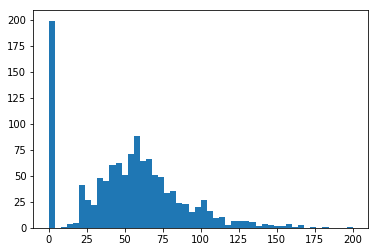

In [32]:
plt.hist(list(map(lambda x: len(x.split()), df_train['findings'])), bins=50)

(array([  3.,  48.,  19.,  17.,  13.,  18., 122.,  17.,  48.,  64.,  54.,
        209.,  57.,  61.,  33., 109.,  39.,  53.,  44.,  25.,  31.,  13.,
         22.,  11.,   9.,  21.,   8.,  12.,   6.,  10.,   4.,   1.,   3.,
          2.,   1.,   5.,   2.,   1.,   3.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([  0.  ,   3.44,   6.88,  10.32,  13.76,  17.2 ,  20.64,  24.08,
         27.52,  30.96,  34.4 ,  37.84,  41.28,  44.72,  48.16,  51.6 ,
         55.04,  58.48,  61.92,  65.36,  68.8 ,  72.24,  75.68,  79.12,
         82.56,  86.  ,  89.44,  92.88,  96.32,  99.76, 103.2 , 106.64,
        110.08, 113.52, 116.96, 120.4 , 123.84, 127.28, 130.72, 134.16,
        137.6 , 141.04, 144.48, 147.92, 151.36, 154.8 , 158.24, 161.68,
        165.12, 168.56, 172.  ]),
 <a list of 50 Patch objects>)

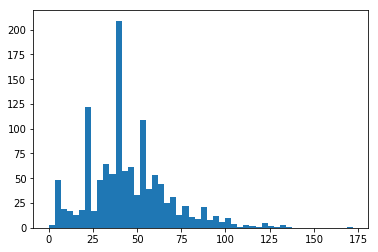

In [34]:
plt.hist(list(map(lambda x: len(x.split()), df_train['impression'])), bins=50)

In [36]:
maxlen = [125, 100]

In [57]:
# get vocab.
x_train_text = utils.Dataframe_Proc.df2text(df_train, df_train.columns[1:])
word2idx, idx2word = utils.Text_Proc.ngram_vocab_processor(x_train_text, ngram=1, min_count=2)
del x_train_text

# Training Set
cache = []
for idx, field in enumerate(df_train.columns[1:]):
    cache.append(np.array(utils.Text_Proc.encode_texts(df_train[field].values, word2idx, maxlen=maxlen[idx])))
x_train = np.concatenate(cache, axis=1)

y_train = df_train[TO_PREDICT].values[:, None]
y_train = np.concatenate([(y_train + 1) / 2, (1 - y_train) / 2], axis=1).astype(np.int)

# Dev Set
cache = []
for idx, field in enumerate(df_train.columns[1:]):
    cache.append(np.array(utils.Text_Proc.encode_texts(df_test[field].values, word2idx, maxlen=maxlen[idx])))
x_dev = np.concatenate(cache, axis=1)    

y_dev = df_test[TO_PREDICT].values[:, None]
y_dev = np.concatenate([(y_dev + 1) / 2, (1 - y_dev) / 2], axis=1).astype(np.int)


In [59]:
maxlen

[125, 100]

**run cnn**

---------

## Classification Model

## Use findings and impression to predict present and pass

In [ ]:
df['history'][1]

In [ ]:
#for PAST without inconsistency
fields = [
    'history', 
    'findings', 
    'comparison', 
    'impression',
]
foo = df[~df['Past'].isnull() & df['Count'] != 1].sample(frac=1)
df_train = foo.iloc[:1240]
y_train = np.array(df_train['Past'].astype(int))
df_test = foo.iloc[1240:]
y_test = np.array(df_test['Past'].astype(int))
obj = utils.Df2TFIDF()
obj.fit(df_train, fields, ngram=5, min_count=5)
output_train = obj.transform(df_train, fields)
output_test = obj.transform(df_test, fields)
# concatenate sparse matrices of all fields
from scipy.sparse import hstack
x_train = hstack([foo['bow_tfidf'] for foo in output_train.itervalues()])
# TODO (xiao)
x_test = hstack([foo['bow_tfidf'] for foo in output_test.itervalues()])
print x_train.shape
print x_test.shape

In [ ]:
#for PRESENT
fields = [
    'history', 
    'findings', 
    'comparison',
    'impression',
]
#'history', 'impression', 'findings', 'comparison'
foo = df[~df['Present'].isnull()].sample(frac=1)
foo = foo.loc[foo['Present']!=0, :]
df_train = foo.iloc[:1100]
y_train = np.array(df_train['Present'].astype(int))
df_test = foo.iloc[1100:]
y_test = np.array(df_test['Present'].astype(int))
obj = utils.Df2TFIDF()
obj.fit(df_train, fields, ngram=5, min_count=2)
output_train = obj.transform(df_train, fields)
output_test = obj.transform(df_test, fields)
# concatenate sparse matrices of all fields
x_train = hstack([foo['bow_tfidf'] for foo in output_train.itervalues()])
x_test = hstack([foo['bow_tfidf'] for foo in output_test.itervalues()])
print x_train.shape
print x_test.shape

In [ ]:
#for Left Grade
fields = ['history', 'findings', 'comparison','impression']
foo = df[~df['Left'].isnull() & df['Left'] != 0].sample(frac=1)
df_train = foo.iloc[:210]
y_train = np.array(df_train['Past'].astype(int))
df_test = foo.iloc[210:]
y_test = np.array(df_test['Past'].astype(int))
obj = utils.Df2TFIDF()
obj.fit(df_train, fields, ngram=5, min_count=5)
output_train = obj.transform(df_train, fields)
output_test = obj.transform(df_test, fields)

# concatenate sparse matrices of all fields
from scipy.sparse import hstack
x_train = hstack([foo['bow_tfidf'] for foo in output_train.itervalues()])
# TODO (xiao)
x_test = hstack([foo['bow_tfidf'] for foo in output_test.itervalues()])
print x_train.shape
print x_test.shape

In [ ]:
#for Left Grade
fields = ['history', 'findings', 'comparison','impression']
foo = df[~df['Right'].isnull() & df['Right'] != 0].sample(frac=1)
df_train = foo.iloc[:200]
y_train = np.array(df_train['Past'].astype(int))
df_test = foo.iloc[200:]
y_test = np.array(df_test['Past'].astype(int))
obj = utils.Df2TFIDF()
obj.fit(df_train, fields, ngram=5, min_count=5)
output_train = obj.transform(df_train, fields)
output_test = obj.transform(df_test, fields)

# concatenate sparse matrices of all fields
from scipy.sparse import hstack
x_train = hstack([foo['bow_tfidf'] for foo in output_train.itervalues()])
# TODO (xiao)
x_test = hstack([foo['bow_tfidf'] for foo in output_test.itervalues()])
print x_train.shape
print x_test.shape

### run classifier

In [ ]:
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
# svm
clf = LinearSVC(C=1, loss='squared_hinge')
#clf = SVC()
#clf = LogisticRegression(C=3)

clf.fit(x_train, y_train)
coef = clf.coef_.squeeze()

In [ ]:
x_train.shape

In [ ]:
y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)
results = pd.concat([utils.my_classification_report(y_train, y_train_pred),
                     utils.my_classification_report(y_test, y_test_pred),
                     ], axis=1).transpose()
results.index = ['training', 'testing']
display(results)

In [ ]:
# features with the big weights
idx = np.absolute(coef).argsort()[::-1]
plt.plot(coef[idx])
plt.show()
idx2word_agg = pd.Series(obj.idx2word_concat)
display(idx2word_agg[idx[:20]])

In [ ]:
# output failed cases.
pd.set_option('display.max_colwidth', -1)
fields = [
    'Past',
    'history', 
    'findings', 
    'comparison', 
    'impression'
]
false_positive = (y_test_pred - y_test) > 0
display(df_test.loc[false_positive,fields].applymap(utils.list2str))

---
# Semi - Supervised Learning

## Prepare data

### Labeled Data

In [ ]:
filename = 'Data/upto1528.xlsx'
df_raw = pd.read_excel(open(filename, 'r'))
# get data frame
ps = utils.Parser()
ps.parser(df_raw)
df = ps.df
for idx, row in df['findings'].iteritems():
    try:
        text, velos = utils.parse_findings(row)
        df.set_value(idx, 'findings', text)
        for n, v in velos:
            df.set_value(idx, n, v)
    except:
        pass
discardField = ['Report Text']
foo = [item for item in df.columns.tolist() if item not in ORDERED_NAMES + discardField]
foo.sort()
CORE_COL = ORDERED_NAMES + foo
df = df[CORE_COL]
df_labeled = pd.concat([df_raw[['Past', 'Present', 'Left', 'Right', 'Count']], df[CORE_COL]], axis=1)

### Unlabeled Data

In [ ]:
filename = 'Data/2011-2016.xlsx'
df_raw = pd.read_excel(open(filename, 'r'))
# get data frame
ps = utils.Parser()
ps.parser(df_raw)
df = ps.df
for idx, row in df['findings'].iteritems():
    try:
        text, velos = utils.parse_findings(row)
        df.set_value(idx, 'findings', text)
        for n, v in velos:
            df.set_value(idx, n, v)
    except:
        pass
discardField = ['Report Text']
foo = [item for item in df.columns.tolist() if item not in ORDERED_NAMES + discardField]
foo.sort()
CORE_COL = ORDERED_NAMES + foo
df_unlabeled = df[CORE_COL]
# df = pd.concat([df_raw[['Past', 'Present', 'Left', 'Right', 'Count']], df[CORE_COL]], axis=1)

----

In [ ]:
#for PAST
fields = [
    'history', 
    'findings', 
    'comparison', 
    'impression'
]
# labeled data
df_labeled = utils.null2empty(df_labeled, fields)
foo = df_labeled[~df_labeled['Past'].isnull() & df_labeled['Past'] != 0].sample(frac=1, random_state=1)
df_train_labeled = foo.iloc[:1220]
y_train_labeled = np.array(df_train_labeled['Past'].astype(int))
y_train_labeled[y_train_labeled==-1] = 0 # turn -1 to 0
df_test = foo.iloc[1220:]
y_test = np.array(df_test['Past'].astype(int))
y_test[y_test==-1] = 0 # turn -1 to 0
obj = utils.Df2TFIDF()
obj.fit(df_train_labeled, fields, ngram=5, min_count=5)
output_train_labeled = obj.transform(df_train_labeled, fields)
output_test = obj.transform(df_test, fields)
# concatenate sparse matrices of all fields
x_train_labeled = hstack([foo['bow_tfidf'] for foo in output_train_labeled.itervalues()])
x_test = hstack([foo['bow_tfidf'] for foo in output_test.itervalues()])
print x_train_labeled.shape
print x_test.shape
# unlabeled data
df_unlabeled = utils.null2empty(df_unlabeled, fields)
# obj = utils.Df2TFIDF()
# obj.fit(df_train_unlabeled, fields, ngram=5, min_count=5)
output_train_unlabeled = obj.transform(df_unlabeled, fields)
x_train_unlabeled = hstack([foo['bow_tfidf'] for foo in output_train_unlabeled.itervalues()])
print x_train_unlabeled.shape

In [ ]:
x_train = vstack([x_train_labeled, x_train_unlabeled])
y_train = np.append(y_train_labeled, np.ones(x_train_unlabeled.shape[0], dtype=int) * -1)

In [ ]:
from sklearn.semi_supervised import LabelPropagation
semi_clf = LabelPropagation(kernel='rbf', gamma=20, n_jobs=-1)
semi_clf.fit(x_train.toarray(), y_train)

In [ ]:
y_train_pred = semi_clf.predict(x_train_labeled.toarray())
y_test_pred = semi_clf.predict(x_test.toarray())
results = pd.concat([utils.my_classification_report(y_train_labeled, y_train_pred),
                     utils.my_classification_report(y_test, y_test_pred),
                     ], axis=1).transpose()
results.index = ['training', 'testing']
display(results)